In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from concurrent.futures import ThreadPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### Загрузка и предварительная очистка данных

In [2]:
train = pd.read_csv('train.csv', sep=',', engine='python')
test = pd.read_csv("test.csv")

In [3]:
train = train.loc[:, ~train.columns.str.contains('Unnamed')]
test = test.loc[:, ~test.columns.str.contains('Unnamed')]
print(train.head())
print("\nКолонки после очистки:", train.columns.tolist())

   id                                              title  \
0   1  Regional African body says ready to work close...   
1   2   New Report Says Trump Destroyed Scaramucci’s ...   
2   3  Hamas chief in Gaza says Palestinian unity dea...   
3   4  Police fire tear gas at Congo opposition leade...   
4   5  PRESIDENT TRUMP Hits Back At Activist Judge On...   

                                                text label  
0  JOHANNESBURG (Reuters) - The Southern African ...     1  
1  Donald Trump s new pick for Communications Dir...     0  
2  GAZA (Reuters) - Palestinian Islamist group Ha...     1  
3  KINSHASA (Reuters) - Police fired tear gas to ...     1  
4  Judge Orrick in California ruled against Presi...     0  

Колонки после очистки: ['id', 'title', 'text', 'label']


In [4]:
train['text'] = train['text'].fillna('')
test['text'] = test['text'].fillna('')

train['label'] = pd.to_numeric(train['label'], errors='coerce')
train['label'] = train['label'].fillna(2)
train['label'] = train['label'].astype(int)
train = train[(train['label'] == 1) | (train['label'] == 0)]

real_text = train[train['label'] == 1]  # Настоящие новости
fake_text = train[train['label'] == 0]  # Фейки

### Графики

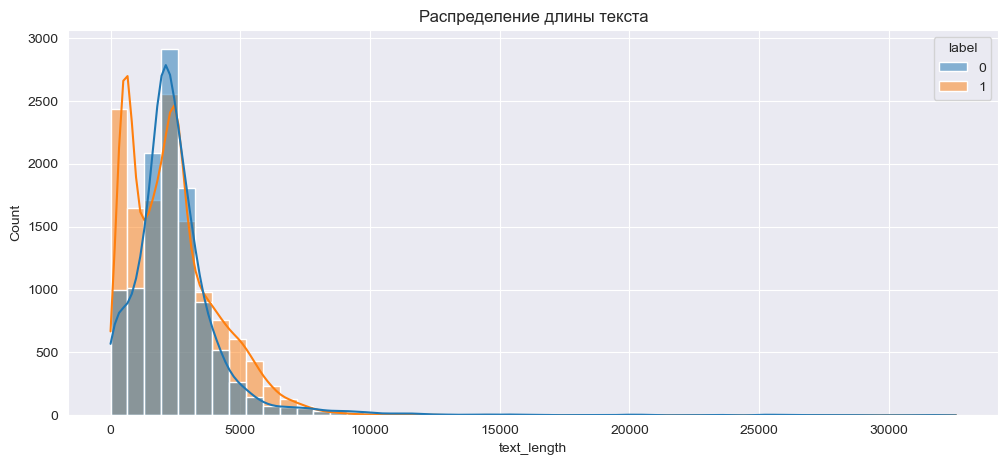

In [5]:
train['text'] = train['text'].astype(str)
train['text_length'] = train['text'].apply(len)

plt.figure(figsize=(12, 5))
sns.histplot(data=train, x='text_length', hue='label', bins=50, kde=True)
plt.title('Распределение длины текста')
plt.show()

In [6]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower(), flags=re.UNICODE)
    return ' '.join(word for word in text.split() if word not in STOPWORDS)


def parallel_clean(texts):
    with ThreadPoolExecutor() as executor:
        return pd.Series(list(executor.map(clean_text, texts)))


STOPWORDS = set(stopwords.words('english'))
real_texts = train[train["label"] == 1]["text"].copy()
fake_texts = train[train["label"] == 0]["text"].copy()

real_texts = parallel_clean(real_texts)
fake_texts = parallel_clean(fake_texts)

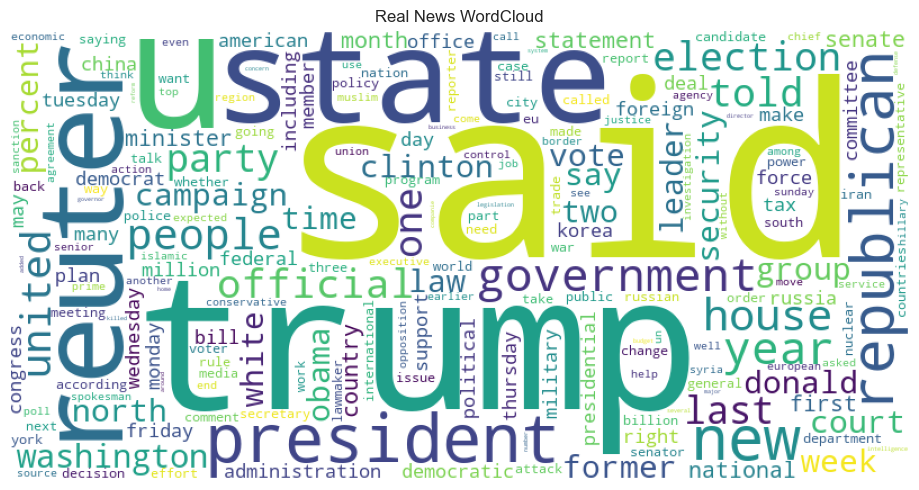

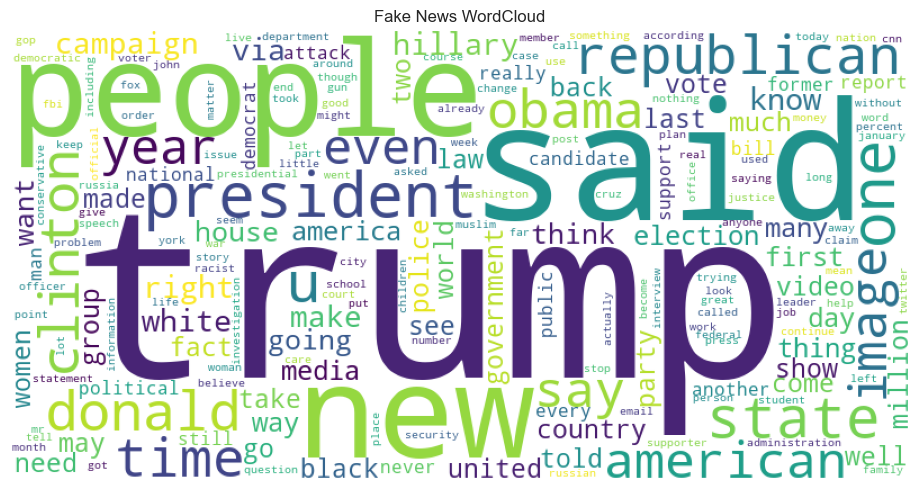

In [7]:
def fast_wordcloud(text_series, title):
    combined_text = ' '.join(text_series[text_series.str.strip().astype(bool)])

    if not combined_text:
        print(f"Текст для '{title}' пуст. Пропускаем.")
        return

    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color="white",
                          collocations=False,
                          max_words=200).generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


fast_wordcloud(real_texts, "Real News WordCloud")
fast_wordcloud(fake_texts, "Fake News WordCloud")

### Статистика по словам

In [8]:
# матрица TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(train['text'])
feature_names = tfidf.get_feature_names_out()

X_real = X[train['label'] == 1]
X_fake = X[train['label'] == 0]

# слова с максимальной разницей в частоте
real_scores = np.asarray(X_real.mean(axis=0)).flatten()
fake_scores = np.asarray(X_fake.mean(axis=0)).flatten()
diff = (fake_scores - real_scores) * 100

# топ-20 характерных слов для каждого класса
top_fake = np.argsort(diff)[-20:][::-1]
top_real = np.argsort(diff)[:20]

print("Топ слов для фейков:", [feature_names[i] for i in top_fake])
print("Топ слов для реальных новостей:", [feature_names[i] for i in top_real])

Топ слов для фейков: ['trump', 'just', 'hillary', 'like', 'image', 'com', 'featured', 'video', 'twitter', 'pic', 'clinton', 'know', 'watch', 'america', 'https', 'obama', 'people', 'black', 'don', 'gop']
Топ слов для реальных новостей: ['said', 'reuters', 'minister', 'washington', 'government', 'korea', 'north', 'china', 'wednesday', 'united', 'state', 'thursday', 'tuesday', 'senate', 'friday', 'eu', 'house', 'monday', 'tax', 'foreign']


In [9]:
def text_stats(df):
    return pd.DataFrame({
        'Длина текста': df['text'].str.len(),
        'Кол-во слов': df['text'].str.split().str.len(),
        'Уникальные слова': df['text'].apply(lambda x: len(set(x.split()))),
        'Ср. длина слова': df['text'].str.split().apply(lambda x: np.mean([len(w) for w in x])),
        'Воскл. знаки': df['text'].str.count('!'),
        'Вопросы': df['text'].str.count(r'\?')
    })


stats_real = text_stats(train[train['label'] == 1]).describe()
stats_fake = text_stats(train[train['label'] == 0]).describe()

print("Реальные новости:\n", stats_real)
print("\nФейковые новости:\n", stats_fake)

C:\Users\2005k\miniconda3\envs\spbu-ai-fundamentals1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Реальные новости:
        Длина текста   Кол-во слов  Уникальные слова  Ср. длина слова  \
count  13246.000000  13246.000000      13246.000000     13246.000000   
mean    2426.443153    393.760758        228.666239         5.166969   
std     1885.297742    311.716722        143.441039         0.271088   
min        4.000000      1.000000          1.000000         3.350000   
25%      919.000000    150.000000        106.000000         5.000000   
50%     2213.000000    359.000000        220.000000         5.165258   
75%     3272.000000    530.000000        307.000000         5.329670   
max    32584.000000   5828.000000       1778.000000         7.800000   

       Воскл. знаки       Вопросы  
count  13246.000000  13246.000000  
mean       0.060547      0.101389  
std        0.411008      0.739381  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max       12.000000     57.000000  

Фейковы

### Пайплайн

In [15]:
class TextStatsExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame()
        df['length'] = X.str.len()
        df['num_words'] = X.str.split().str.len()
        df['unique_words'] = X.apply(lambda x: len(set(x.split())))
        df['avg_word_len'] = X.str.split().apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
        df['exclamations'] = X.str.count('!')
        df['questions'] = X.str.count(r'\?')
        df['ratio_caps'] = X.apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
        return df.fillna(0).values

In [17]:
text_tfidf = Pipeline([
    ('extract_text', FunctionTransformer(lambda x: x['text'], validate=False)),
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english'))
])

text_stats = Pipeline([
    ('extract_text', FunctionTransformer(lambda x: x['text'], validate=False)),
    ('stats', TextStatsExtractor()),
    ('scale', StandardScaler())
])

features = FeatureUnion([
    ('tfidf', text_tfidf),
    ('stats', text_stats)
])

In [12]:
X = train[['text', 'title']]
y = train['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Catboost with Gridsearch

In [18]:
cat_pipeline = Pipeline([
    ('features', features),
    ('clf', CatBoostClassifier(verbose=0, random_state=42))
])

cat_params = {
    'clf__iterations': [200],
    'clf__depth': [4, 6],
    'clf__learning_rate': [0.05, 0.1]
}

cat_grid = GridSearchCV(cat_pipeline,
                        param_grid=cat_params,
                        scoring='f1',
                        cv=3,
                        verbose=3,  
                        n_jobs=-1)

cat_grid.fit(X_train, y_train)
cat_pred = cat_grid.predict(X_val)
print("CatBoost F1:", f1_score(y_val, cat_pred))
print("Лучшие параметры CatBoost:", cat_grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CatBoost F1: 0.9790794979079498
Лучшие параметры CatBoost: {'clf__depth': 6, 'clf__iterations': 200, 'clf__learning_rate': 0.1}


#### Xgboost with Gridsearch

In [19]:
xgb_pipeline = Pipeline([
    ('features', features),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_params = {
    'clf__n_estimators': [150],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.05, 0.1],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, scoring='f1', cv=3, n_jobs=-1, verbose=3)

xgb_grid.fit(X_train, y_train)
xgb_pred = xgb_grid.predict(X_val)
print("XGBoost F1:", f1_score(y_val, xgb_pred))
print("Лучшие параметры XGBoost:", xgb_grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\2005k\miniconda3\envs\spbu-ai-fundamentals1\lib\site-packages\xgboost\core.py:158: UserWarning: [12:19:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost F1: 0.9817490494296578
Лучшие параметры XGBoost: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 150, 'clf__subsample': 0.8}


#### Xgboost with randomized search

In [20]:
xgb_pipeline = Pipeline([
    ('features', features),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_params = {
    'clf__n_estimators': [80, 100, 120],
    'clf__max_depth': [3, 4],
    'clf__learning_rate': [0.05, 0.1],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

xgb_pred = xgb_search.predict(X_val)
print("\nXGBoost F1:", f1_score(y_val, xgb_pred))
print("Лучшие параметры XGBoost:", xgb_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\2005k\miniconda3\envs\spbu-ai-fundamentals1\lib\site-packages\xgboost\core.py:158: UserWarning: [12:22:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost F1: 0.9819219790675546
Лучшие параметры XGBoost: {'clf__subsample': 0.8, 'clf__n_estimators': 120, 'clf__max_depth': 4, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8}


#### Ensemble

In [21]:
best_xgb = xgb_grid.best_estimator_
best_cat = cat_grid.best_estimator_

best_xgb.fit(X_train, y_train)
best_cat.fit(X_train, y_train)

xgb_proba = best_xgb.predict_proba(X_val)[:, 1]
cat_proba = best_cat.predict_proba(X_val)[:, 1]

avg_proba = (xgb_proba + cat_proba) / 2
ensemble_pred = (avg_proba > 0.5).astype(int)

print("Ансамбль F1:", f1_score(y_val, ensemble_pred))

C:\Users\2005k\miniconda3\envs\spbu-ai-fundamentals1\lib\site-packages\xgboost\core.py:158: UserWarning: [12:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ансамбль F1: 0.9817490494296578


### Save submission

In [89]:
test_preds = xgb_search.predict(test)

submission = pd.DataFrame({
    'id': test['id'],
    'label': test_preds
})

submission.to_csv("submission.csv", index=False)

In [91]:
xgb_test_proba = best_xgb.predict_proba(test)[:, 1]
cat_test_proba = best_cat.predict_proba(test)[:, 1]

avg_test_proba = (xgb_test_proba + cat_test_proba) / 2
ensemble_test_pred = (avg_test_proba > 0.5).astype(int)

submission = pd.DataFrame({
    'id': test['id'],
    'label': ensemble_test_pred
})
submission.to_csv("ensemble_submission.csv", index=False)